# ***Bank Churn with LightGBM, XGBoost, and CatBoost***

![Bank Image](https://www.shutterstock.com/image-photo/washington-17-2019-two-security-600nw-2389314207.jpg)



# ***Table of Content***
***1. About the Dataset***\
***2. Import Libraries***\
***3. Data Exploration***\
***4. Data Visualization***\
***5. Data Preprocessing***\
***6. Model Building***\
***7. Conclussions***

# ***1. About the Dataset***


`Title`: ***Bank Customer Churn Prediction***

`Context`: *The dataset contains information about bank customers and their banking activities. It includes features such as customer demographics, banking products, transactions, and customer behavior. The goal is to predict whether a customer will churn (leave the bank) or not based on the provided features.*

`Columns Description:`

- *`Customer ID:` A unique identifier for each customer*
- *`Surname:` The customer's surname or last name*
- *`Credit Score:` A numerical value representing the customer's credit score*
- *`Geography:` The country where the customer resides (France, Spain or Germany)*
- *`Gender:` The customer's gender (Male or Female)*
- *`Age:` The customer's age.*
- *`Tenure:` The number of years the customer has been with the bank*
- *`Balance:` The customer's account balance*
- *`NumOfProducts:` The number of bank products the customer uses (e.g., savings account, credit card)*
- *`HasCrCard:` Whether the customer has a credit card (1 = yes, 0 = no)*
- *`IsActiveMember:` Whether the customer is an active member (1 = yes, 0 = no)*
- *`EstimatedSalary:` The estimated salary of the customer*
- *`Exited:` Whether the customer has churned (1 = yes, 0 = no)*

# ***2. Import Libraries***

In [1]:
# import libraries

# to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# to preprocess the data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder    

# machine learning
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

# model
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

# evaluation
from sklearn.metrics import roc_auc_score, accuracy_score

# max columns 
pd.set_option('display.max_columns', None)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# ***3. Data Exploration***

> ***1. Load the Dataset***

In [2]:
# submission data
df_submission = pd.read_csv("./input/sample_submission.csv")

# train data
df_train = pd.read_csv("./input/train.csv")
# test data

df_test = pd.read_csv("./input/test.csv")
# train data

In [3]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


> ***2. Checking the number of rows and columns***


In [4]:
# checking the number of rows and columns
num_train_rows, num_train_columns = df_train.shape
num_test_rows, num_test_columns = df_test.shape
num_submission_rows, num_submission_columns = df_submission.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Submission Data:")
print(f"Number of Rows: {num_submission_rows}")
print(f"Number of Columns: {num_submission_columns}\n")

Training Data:
Number of Rows: 165034
Number of Columns: 14

Test Data:
Number of Rows: 110023
Number of Columns: 13

Submission Data:
Number of Rows: 110023
Number of Columns: 2



> ***3. Checking for null values***

In [5]:
# Null values in dataset
train_null = df_train.isnull().sum().sum()
test_null = df_test.isnull().sum().sum()

print(f"Null count in Training Data: {train_null}")
print(f"Null count in Test Data: {test_null}")

Null count in Training Data: 0
Null count in Test Data: 0


> ***4. Checking for duplicate values***

In [6]:
# duplicate values
train_duplicate = df_train.drop("id", axis=1).duplicated().sum()
test_duplicate = df_test.drop("id", axis=1).duplicated().sum()

print(f"Duplicate count in Training Data: {train_duplicate}")
print(f"Duplicate count in Test Data: {test_duplicate}")

Duplicate count in Training Data: 0
Duplicate count in Test Data: 0


> ***5. Explore the training data***

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


> ***5.1  Observation No 1***

- *There are 165034 rows and 14 columns in the dataset.*
- *The columns having float datatypes are 5, integer datatype 6, object datatype are 3*
- *The data does not contain any missing values*
- *The target variable in the dataset is Exited.*

> ***6. Descriptive Analysis***


In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


# ***4. Data Visualization***


In [9]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


> ***1. Checking distrubution of target variable***

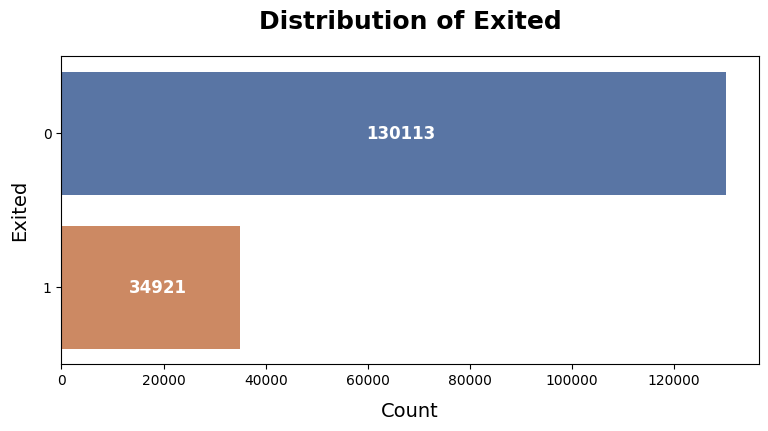

In [10]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 4))

# Create the count plot
sns.countplot(y="Exited", data=df_train, ax=ax, palette="deep")

# Customize the plot
ax.set_title("Distribution of Exited", fontsize=18, fontweight='semibold', pad=20)
ax.set_xlabel("Count", fontsize=14, labelpad=10)
ax.set_ylabel("Exited", fontsize=14, labelpad=10)

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, padding=5, color='white', fontweight='bold')

plt.show()

> ***1.1 Observation No 2***

- *The target variable is imbalanced, so we will use stratified cross-validation for this imbalanced dataset.*

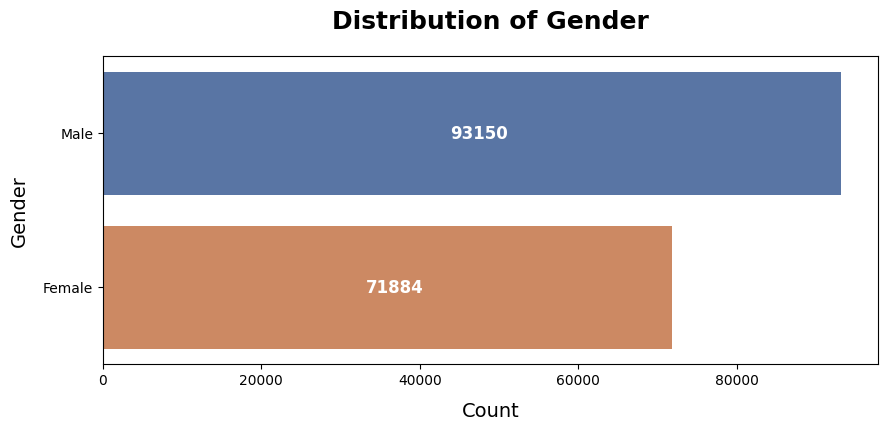

In [11]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 4))

# Create the count plot
sns.countplot(y="Gender", data=df_train, ax=ax, palette="deep")

# Customize the plot
ax.set_title("Distribution of Gender", fontsize=18, fontweight='semibold', pad=20)
ax.set_xlabel("Count", fontsize=14, labelpad=10)
ax.set_ylabel("Gender", fontsize=14, labelpad=10)

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, padding=5, color='white', fontweight='bold')

plt.show()

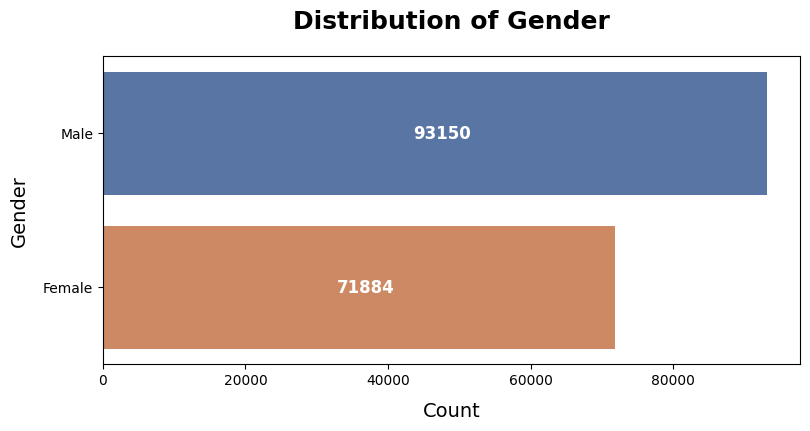

In [12]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 4))

# Create the count plot
sns.countplot(y="Gender", data=df_train, ax=ax, palette="deep")

# Customize the plot
ax.set_title("Distribution of Gender", fontsize=18, fontweight='semibold', pad=20)
ax.set_xlabel("Count", fontsize=14, labelpad=10)
ax.set_ylabel("Gender", fontsize=14, labelpad=10)

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, padding=5, color='white', fontweight='bold')

plt.show()

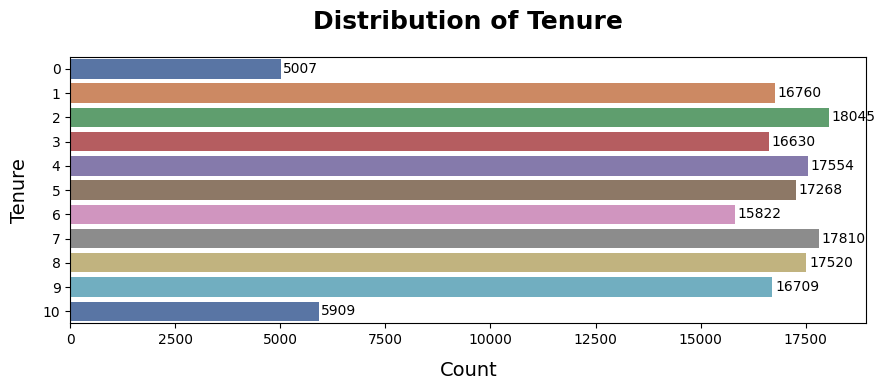

In [13]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 4))

# Create the count plot
sns.countplot(y="Tenure", data=df_train, ax=ax, palette="deep")

# Customize the plot
ax.set_title("Distribution of Tenure", fontsize=18, fontweight='semibold', pad=20)
ax.set_xlabel("Count", fontsize=14, labelpad=10)
ax.set_ylabel("Tenure", fontsize=14, labelpad=10)

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=2, color='black', fontweight='normal')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

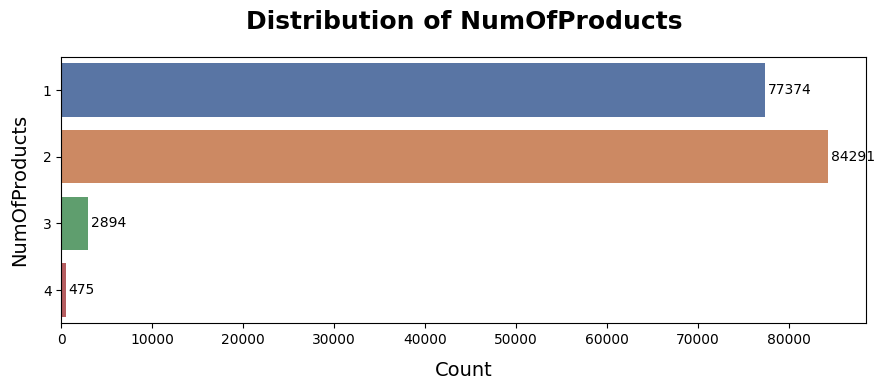

In [14]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 4))

# Create the count plot
sns.countplot(y="NumOfProducts", data=df_train, ax=ax, palette="deep")

# Customize the plot
ax.set_title("Distribution of NumOfProducts", fontsize=18, fontweight='semibold', pad=20)
ax.set_xlabel("Count", fontsize=14, labelpad=10)
ax.set_ylabel("NumOfProducts", fontsize=14, labelpad=10)

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=2, color='black', fontweight='normal')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

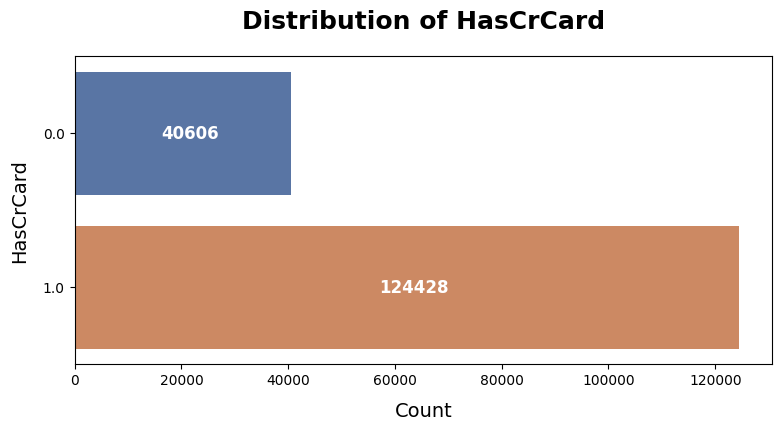

In [15]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 4))

# Create the count plot
sns.countplot(y="HasCrCard", data=df_train, ax=ax, palette="deep")

# Customize the plot
ax.set_title("Distribution of HasCrCard", fontsize=18, fontweight='semibold', pad=20)
ax.set_xlabel("Count", fontsize=14, labelpad=10)
ax.set_ylabel("HasCrCard", fontsize=14, labelpad=10)

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, padding=5, color='white', fontweight='bold')

plt.show()

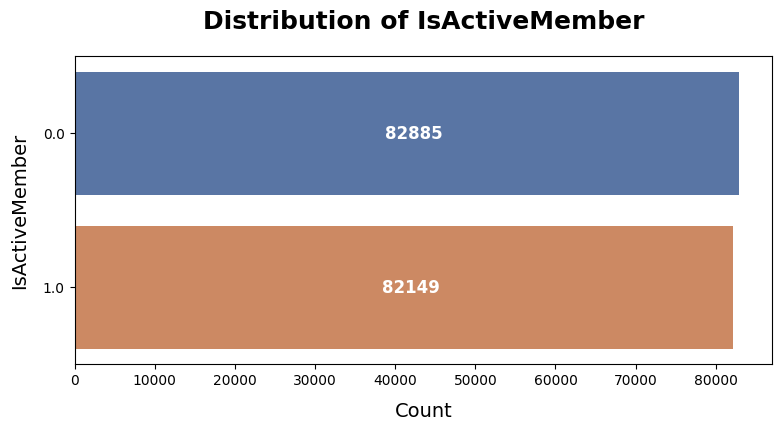

In [16]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 4))

# Create the count plot
sns.countplot(y="IsActiveMember", data=df_train, ax=ax, palette="deep")

# Customize the plot
ax.set_title("Distribution of IsActiveMember", fontsize=18, fontweight='semibold', pad=20)
ax.set_xlabel("Count", fontsize=14, labelpad=10)
ax.set_ylabel("IsActiveMember", fontsize=14, labelpad=10)

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, padding=5, color='white', fontweight='bold')

plt.show()

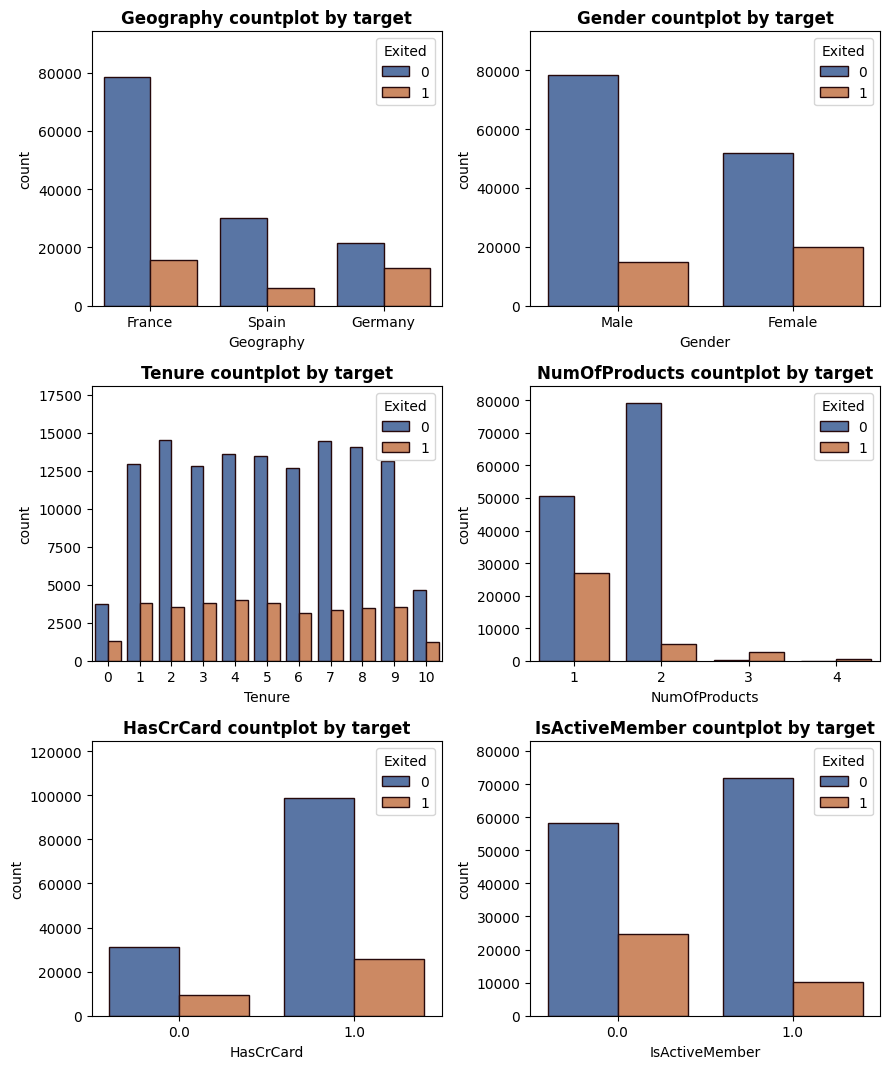

In [17]:
cat_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

target = 'Exited'

fig = plt.figure(figsize=(9, len(cat_cols)*1.8))

# background_color = 'grey'
for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=df_train, palette='deep', color='#26090b', edgecolor='#26090b')
    plt.title(f"{col} countplot by target", fontweight = 'bold')
    plt.ylim(0, df_train[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

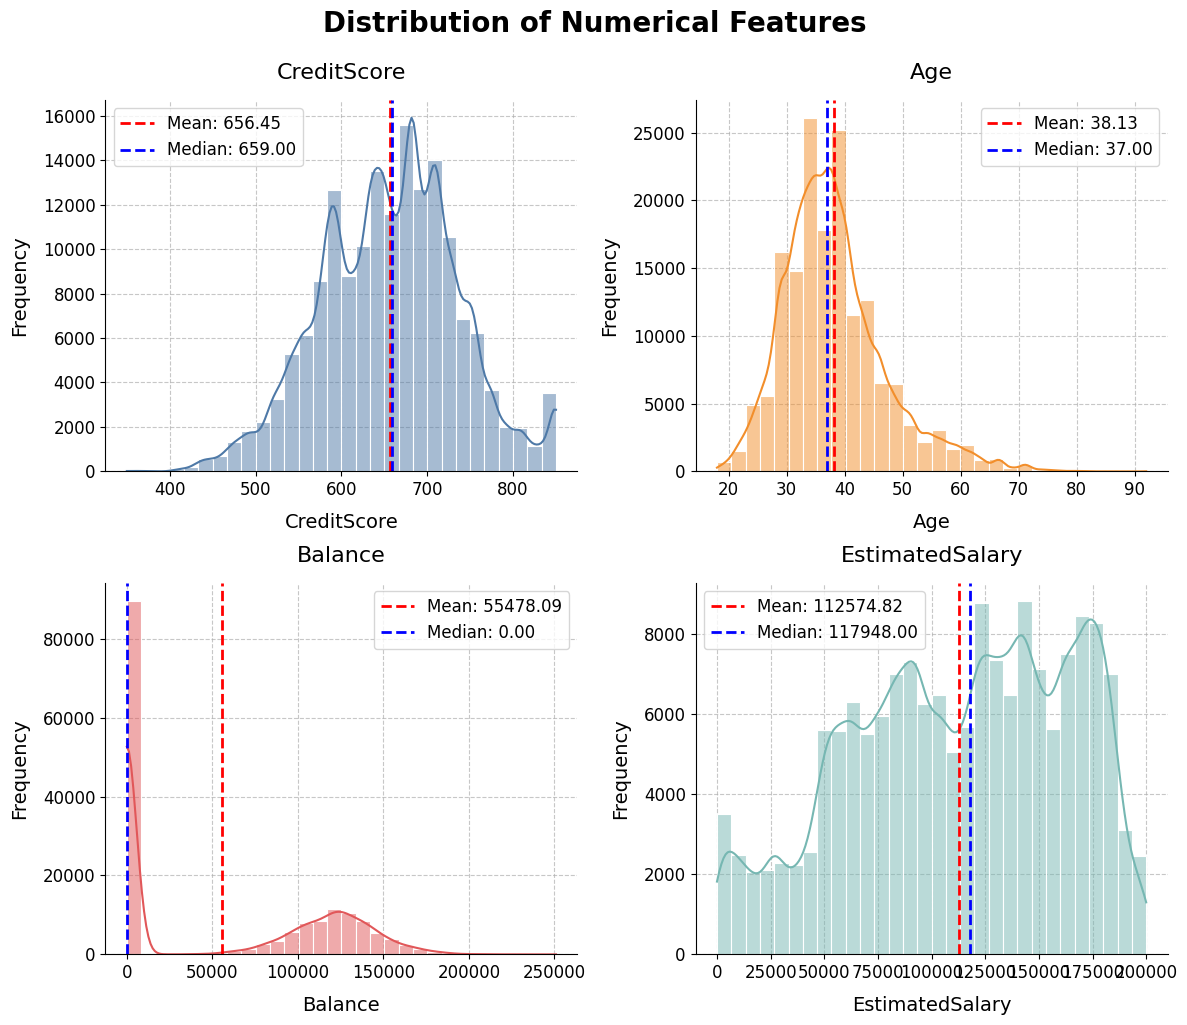

In [18]:
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Distribution of Numerical Features", fontsize=20, fontweight='bold', y=1.02)

for i, column in enumerate(num_cols):
    ax = axes[i//2, i%2]
    sns.histplot(data=df_train, x=column, kde=True, bins=30, ax=ax, color=colors[i], edgecolor='white', linewidth=0.8)
    
    mean, median = df_train[column].mean(), df_train[column].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

    ax.set_title(column, fontsize=16, pad=15)
    ax.set_xlabel(column, fontsize=14, labelpad=10)
    ax.set_ylabel('Frequency', fontsize=14, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=12)

plt.tight_layout()
fig.subplots_adjust(top=0.93, hspace=0.3, wspace=0.25)
plt.show()

> Correlation Matrix

*Correlation analysis in machine learning measures relationships between variables, aiding in feature selection and model interpretation. It identifies patterns, dependencies, and insights by quantifying associations. This technique helps reduce multicollinearity and improve model accuracy by informing decisions on feature inclusion.*

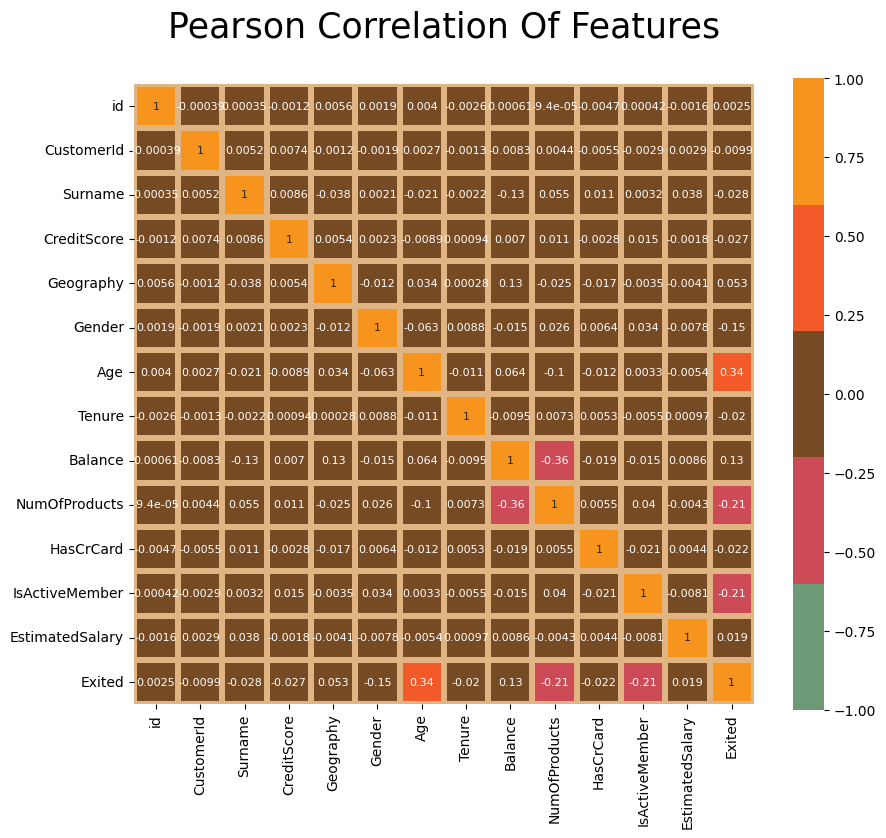

In [19]:
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]
df_corr = df_train.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        df_corr[col] = le.fit_transform(df_corr[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(df_corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =8))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


*We can see here that there is a strong positive correlation between the Age and the churn, which means that when the age is larger, the possibility of churn is larger, which can tell us that as a person gets older it's more probable that they will chur.*

*Also we can see a strong negative correlation this time between the (Number of Products and Is active member) with the exited probability, which tells us that when a person is more active the probability of them exiting is low, also when a client has more products in the bank, they are less probable to churn.*

*From this we can see that these two variables are strongly important in the decision of the probability of a customer churn.*

# ***5. Data Preprocessing***

> ***1. Data Scaling***

In [20]:
numeirc_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
#Use Loop Function
for col in numeirc_cols:
    sc = MinMaxScaler()
    df_train[col+"_scaled"] = sc.fit_transform(df_train[[col]])
    df_test[col+"_scaled"] = sc.fit_transform(df_test[[col]])

> ***2. TF-IDF Vectorization for Surname***

*Credit = @Aravind Pillai*

*Link : https://www.kaggle.com/code/aspillai/bank-churn-dataset-classification-lightgbm?scriptVersionId=160081126&cellId=11*

*Applying TF-IDF to the "Surname" column may necessitate preprocessing steps, such as handling variations in case or stemming, to ensure that similar surnames are treated consistently. Additionally, the TF-IDF scores can be used as features for machine learning models.*

*TF-IDF will highlight surnames that are unique or less common in the dataset. Surnames with higher TF-IDF scores are those that appear frequently in a specific record but less frequently across the entire dataset.*

*If you apply TF-IDF vectorization to this "Surname" column and then use techniques like dimensionality reduction with SVD, it makes sense in the context of processing textual data for machine learning. This approach can help capture the importance of different words (in this case, surnames) and potentially improve the performance of your machine learning model.*

> ***Create Combined Feature: Sur_Geo_Gend_Sal***

In [21]:
# Combining Customerid, Surname, Geography, and Gender, Estimated Slaray and Making New Column in both Data Frames 
df_train['Sur_Geo_Gend_Sal'] = df_train['CustomerId'].astype('str')+df_train['Surname']+df_train['Geography']+df_train['Gender']+np.round(df_train.EstimatedSalary).astype('str')
df_test['Sur_Geo_Gend_Sal'] = df_test['CustomerId'].astype('str')+df_test['Surname']+df_test['Geography']+df_test['Gender']+np.round(df_test.EstimatedSalary).astype('str')

*The `get_vectors` function takes two DataFrames `df_train` and `df_test`, and a specified column name `col_name`. It performs the following steps:*

*1. Utilizes the `TfidfVectorizer` to transform the text data in the specified column into TF-IDF vectors, limiting the features to a maximum of 1000.*

*2. Applies dimensionality reduction using `TruncatedSVD` with 3 components to further transform the TF-IDF vectors.*

*3. Converts the transformed vectors into DataFrames (`tfidf_df_train` and `tfidf_df_test`).*

*4. Names the columns in the new DataFrames with a combination of the original column name and additional information.*

*5. Resets the index of the original DataFrames before concatenation.*

*6. Concatenates the transformed features with the original data along the columns.*

*7. Returns the modified training and testing DataFrames.*

*This function effectively combines TF-IDF vectorization and dimensionality reduction to enhance the original DataFrames with transformed features, facilitating machine learning tasks that involve text data.*

In [22]:
def get_vectors(df_train,df_test,col_name):

    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    #Dimensionality Reduction Using SVD ( Singular Value Decompostion)
    svd = TruncatedSVD(3)
    x_sv_train = svd.fit_transform(vectors_train)
    x_sv_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_sv_train)
    tfidf_df_test = pd.DataFrame(x_sv_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train,df_test

In [23]:
df_train,df_test = get_vectors(df_train,df_test,'Surname')
df_train,df_test = get_vectors(df_train,df_test,'Sur_Geo_Gend_Sal')

In [24]:
# Head Of Train after Vectorization
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Sur_Geo_Gend_Sal,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.202703,0.636,0.000000,0.907279,15674932OkwudilichukwuFranceMale181450.0,-3.972256e-08,-7.654316e-07,-1.182287e-07,0.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.202703,0.554,0.000000,0.247483,15749177OkwudiliolisaFranceMale49504.0,-2.289407e-07,1.797497e-06,-6.567174e-09,0.0,0.0,0.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.297297,0.656,0.000000,0.924364,15694510HsuehFranceMale184867.0,-7.663623e-05,-5.565853e-04,3.526603e-04,0.0,0.0,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.216216,0.462,0.593398,0.422787,15741417KaoFranceMale84561.0,2.000562e-05,-2.023741e-03,1.008233e-04,0.0,0.0,0.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.202703,0.732,0.000000,0.075293,15766172ChiemenamSpainMale15069.0,9.672065e-08,-8.945234e-08,3.204834e-07,0.0,0.0,0.0


> ***3. Feature Engineering***

In [25]:
def feature_data(df):
    
    df['Senior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['Active_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    
    cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']
    #onehotEncoding
    df=pd.get_dummies(df,columns=cat_cols)
    return df

In [26]:
#Genrating New Features
df_train = feature_data(df_train)
df_test = feature_data(df_test)

##Selecting Columns FOr use 
feat_cols=df_train.columns.drop(['id', 'CustomerId', 'Surname','Exited','Sur_Geo_Gend_Sal'])
feat_cols=feat_cols.drop(numeirc_cols)

#Printing
print(feat_cols)
df_train.head()

Index(['Tenure', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Sur_Geo_Gend_Sal_tfidf_0', 'Sur_Geo_Gend_Sal_tfidf_1',
       'Sur_Geo_Gend_Sal_tfidf_2', 'Senior', 'Active_by_CreditCard',
       'Products_Per_Tenure', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'AgeCat_1',
       'AgeCat_2', 'AgeCat_3', 'AgeCat_4', 'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,Sur_Geo_Gend_Sal,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2,Senior,Active_by_CreditCard,Products_Per_Tenure,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,0,0.202703,0.636,0.000000,0.907279,15674932OkwudilichukwuFranceMale181450.0,-3.972256e-08,-7.654316e-07,-1.182287e-07,0.0,0.0,0.0,0,0.0,1.5,True,False,False,False,True,False,True,False,False,False,True,False,False,False
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,0,0.202703,0.554,0.000000,0.247483,15749177OkwudiliolisaFranceMale49504.0,-2.289407e-07,1.797497e-06,-6.567174e-09,0.0,0.0,0.0,0,1.0,0.5,True,False,False,False,True,False,True,False,False,False,True,False,False,False
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,0,0.297297,0.656,0.000000,0.924364,15694510HsuehFranceMale184867.0,-7.663623e-05,-5.565853e-04,3.526603e-04,0.0,0.0,0.0,0,0.0,5.0,True,False,False,False,True,False,True,False,False,False,True,False,False,False
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,0,0.216216,0.462,0.593398,0.422787,15741417KaoFranceMale84561.0,2.000562e-05,-2.023741e-03,1.008233e-04,0.0,0.0,0.0,0,1.0,2.0,True,False,False,False,True,True,False,False,False,False,True,False,False,False
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,0,0.202703,0.732,0.000000,0.075293,15766172ChiemenamSpainMale15069.0,9.672065e-08,-8.945234e-08,3.204834e-07,0.0,0.0,0.0,0,1.0,2.5,False,False,True,False,True,False,True,False,False,False,True,False,False,False


> ***4. Split data into X and y***

In [27]:
X=df_train[feat_cols]
y=df_train['Exited']

In [28]:
print(f'The Shape Of X is {X.shape}')
print(f'The Shape Of y is {y.shape}')

The Shape Of X is (165034, 30)
The Shape Of y is (165034,)


# ***6. Model Building***

***We will use three boosting models.***

*1. LightBGM Classifier*\
*2. CatBoost Classifier*\
*3. XGBoost Classifier*

### ***6.1 LightGBM Classifier***

In [29]:
# LightGBM Parameters
lgbParams = {'n_estimators': 1000,
             'max_depth': 25, 
             'learning_rate': 0.025,
             'min_child_weight': 3.43,
             'min_child_samples': 216, 
             'subsample': 0.782,
             'subsample_freq': 4, 
             'colsample_bytree': 0.29, 
             'num_leaves': 21,
             'verbose':-1}

lgb_model = lgb.LGBMClassifier(**lgbParams)
lgb_cv_scores = cross_val_score(lgb_model, X, y, cv=10, scoring='roc_auc')

print("Cross-validation scores:", lgb_cv_scores)
print("Mean AUC:", lgb_cv_scores.mean())

Cross-validation scores: [0.89413896 0.8999152  0.89326488 0.89228824 0.89653752 0.89199692
 0.89422018 0.8935102  0.89424751 0.89364407]
Mean AUC: 0.8943763678941179


> ***Create Submission File***

In [30]:
# before prediction we need to fit the data
lgb_model.fit(X,y)

test_predictions = lgb_model.predict_proba(df_test[feat_cols])[:, 1]

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': df_test['id'],
    'Exited': test_predictions
})

# # Save the submission file
submission.to_csv('submission/lgbm_submission.csv', index=False)

print("Submission file created: lgbm_submission.csv")

Submission file created: lgbm_submission.csv


### ***6.2 CatBoost Classifier***

In [31]:
# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.022,
    iterations=1000,
    verbose=False
)

# Perform cross-validation with StratifiedKFold
catboost_cv_scores = cross_val_score(cat_model, X, y, cv=5, scoring='roc_auc')

print("Cross-validation scores:", catboost_cv_scores)
print("Mean AUC:", catboost_cv_scores.mean())

Cross-validation scores: [0.89590557 0.89132116 0.89337373 0.89224542 0.89247498]
Mean AUC: 0.8930641720156896


> ***Create Submission File***

In [32]:
#Cat_features
cat_features = np.where(X.dtypes != np.float64)[0]

# Train the model on the entire dataset
train_pool = Pool(X, y, cat_features=cat_features)
cat_model.fit(train_pool)

# Make predictions on the test set
test_pool = Pool(df_test[feat_cols], cat_features=cat_features)
test_predictions = cat_model.predict_proba(test_pool)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'id': df_test['id'],
    'Exited': test_predictions
})

# Save the submission file
submission.to_csv('submission/catboost_submission.csv', index=False)
print("Submission file created: catboost_submission.csv")

Submission file created: catboost_submission.csv


### ***6.3 XGBoost Classifier***

In [33]:
# XGBoost Parameters
xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'nthread': -1,
    'random_state': 42
}

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(**xgb_params)

# Perform cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc')

print("Cross-validation scores:", xgb_cv_scores)
print("Mean AUC:", xgb_cv_scores.mean())

Cross-validation scores: [0.8928834  0.89334654 0.89441785 0.89433639 0.89105769]
Mean AUC: 0.8932083741221222


> ***Create Submission File***

In [34]:
# Train the model on the entire dataset
xgb_model.fit(X, y)

# Make predictions on the test set
test_predictions = xgb_model.predict_proba(df_test[feat_cols])[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'id': df_test['id'],
    'Exited': test_predictions
})

# Save the submission file
submission.to_csv('submission/xgboost_submission.csv', index=False)
print("Submission file created: xgboost_submission.csv")

Submission file created: xgboost_submission.csv


# ***7. Conclusions***

In [35]:
classifiers = ['LightGBM', 'CatBoost', 'XGBoost']
auc_scores = [lgb_cv_scores.mean(), catboost_cv_scores.mean(), xgb_cv_scores.mean()]

In [36]:
# Create data for the plot
colors = ['#4e79a7', '#f28e2b', '#e15759']

# Create the figure with optimized settings
fig = go.Figure(data=[go.Bar(
    x=classifiers,
    y=auc_scores,
    name='AUC Score',
    marker_color=colors
)])

# Update layout with optimized settings
fig.update_layout(
    title='AUC Comparison',
    xaxis_title='Classifier',
    yaxis_title='AUC Score',
    template='plotly_white',
    font=dict(family="Arial", size=12),
    width=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Add gridlines
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E0E0E0')

# Show the plot
fig.show()

In [37]:
# Selcting Best and Highest AUC_Score  from Above trained Models 

# Find the index of the maximum AUc_Score
best_accuracy_index = auc_scores.index(max(auc_scores))

# Print the best model for accuracy
print(f'Best Accuracy: {auc_scores[best_accuracy_index]:.4f} with Model: {classifiers[best_accuracy_index]}')

Best Accuracy: 0.8944 with Model: LightGBM


# ***The End***

*I will be trying to improve this notebook, and I will keep updating the public version to help everyone understand as much as I can. Make sure to upvote if you find this helpful. Also, please comment your feedback below, as it would help me improve.*